In [1]:
# !pip uninstall tensorflow opencv-python opencv-contrib-python mediapipe numpy -y

Found existing installation: opencv-contrib-python 4.8.1.78
Uninstalling opencv-contrib-python-4.8.1.78:
  Successfully uninstalled opencv-contrib-python-4.8.1.78
Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


You can safely remove it manually.
You can safely remove it manually.


# Dependencies and imports

In [3]:
!pip install numpy==1.26.4
!pip install opencv-contrib-python==4.8.1.78
!pip install mediapipe 
!pip install tensorflow scikit-learn matplotlib

  Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl.metadata (541 bytes)
Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl (413 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.32.1
    Uninstalling protobuf-6.32.1:
      Successfully uninstalled protobuf-6.32.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.
streamlit 1.37.1 requires rich<14,>=10.14.0, but you have rich 14.1.0 which is incompatible.
tensorflow 2.20.0 requires protobuf>=5.28.0, but you have protobuf 4.25.8 which is incompatible.


  Using cached protobuf-6.32.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
Using cached protobuf-6.32.1-cp310-abi3-win_amd64.whl (435 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires protobuf<5,>=4.25.3, but you have protobuf 6.32.1 which is incompatible.
streamlit 1.37.1 requires packaging<25,>=20, but you have packaging 25.0 which is incompatible.
streamlit 1.37.1 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.32.1 which is incompatible.
streamlit 1.37.1 requires rich<14,>=10.14.0, but you have rich 14.1.0 which is incompatible.


In [4]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import datetime
import mediapipe as mp
import tensorflow as tf
from time import sleep
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [5]:
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("MediaPipe:", mp.__version__)
print("TensorFlow:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

NumPy: 1.26.4
OpenCV: 4.8.1
MediaPipe: 0.10.21
TensorFlow: 2.20.0
GPUs available: []


# MediaPipe Holistic for keypoints extraction

In [7]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [8]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [9]:
face_style = mp_drawing.DrawingSpec(color=(0, 255, 255), thickness=1, circle_radius=1)
face_points = mp_drawing.DrawingSpec(color=(0, 128, 255), thickness=1, circle_radius=1)

pose_style = mp_drawing.DrawingSpec(color=(255, 128, 0), thickness=2, circle_radius=4)
pose_points = mp_drawing.DrawingSpec(color=(255, 200, 100), thickness=1, circle_radius=2)

left_hand_style = mp_drawing.DrawingSpec(color=(147, 112, 219), thickness=2, circle_radius=4)
left_hand_points = mp_drawing.DrawingSpec(color=(186, 85, 211), thickness=1, circle_radius=2)

right_hand_style = mp_drawing.DrawingSpec(color=(60, 179, 113), thickness=2, circle_radius=4)
right_hand_points = mp_drawing.DrawingSpec(color=(144, 238, 144), thickness=1, circle_radius=2)

In [10]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, face_style, face_points)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, pose_style, pose_points) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, left_hand_style, left_hand_points)   
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, right_hand_style, right_hand_points) 

In [40]:
cap = cv2.VideoCapture(0)
 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        
        draw_landmarks(image, results)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [19]:
# l/r hand -> 21 (x,y,z), pose -> 33 (x,y,z,visibility), face -> 468 (x,y,z)
len(results.face_landmarks.landmark)

468

In [17]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [23]:
result_test = extract_keypoints(results)
len(result_test)

1662

# Data collection

In [19]:
DATA_PATH = os.path.join('MSL_Data')

In [21]:
actions = np.array(['А', 'Б', 'В', 'Г', 'Д', 'Ѓ', 'Е', 'Ж', 'З', 'Ѕ', 'И', 'Ј', 'К', 'Л', 'Љ', 'М', 'Н', 'Њ',
                   'О', 'П', 'Р', 'С', 'Т', 'Ќ', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Џ', 'Ш'])

action_labels = np.array(['A', 'B', 'V', 'G', 'D', 'Gj', 'E', 'Zh', 'Z', 'Dz', 'I', 'J', 'K', 'L', 'Lj', 'M', 'N', 'Nj',
                   'O', 'P', 'R', 'S', 'T', 'Kj', 'U', 'F', 'H', 'C', 'Ch', 'Dj', 'Sh'])

In [23]:
words = np.array(['Добро', 'Здраво', 'Како сте', 'Лошо', 'Пријатно', 'Поздравување', 'Така Така', 'Бела', 'Безбојно', 'Боја', 'Бои', 'Жолта', 
                  'Златна', 'Кафеава', 'Месо боја', 'Плава', 'Портокалова', 'Розева', 'Светла', 'Сива', 'Сребро', 'Темна', 'Црвена', 'Црна', 
                  'Црна (втор знак)', 'Веб страна', 'Компјутер', 'Лаптоп', 'Мобилна мрежа', 'Рутер'])

word_labels = np.array(['Dobro', 'Zdravo', 'Kako ste', 'Losho', 'Prijatno', 'Pozdravuvanje', 'Taka Taka', 'Bela', 'Bezbojno', 'Boja', 'Boi', 'Zolta', 
                        'Zlatna', 'Kafeava', 'Meso boja', 'Plava', 'Portokalova', 'Rozeva', 'Svetla', 'Siva', 'Srebro', 'Temna', 'Crvena', 'Crna', 
                        'Crna (vtor znak)', 'Veb strana', 'Kompjuter', 'Laptop', 'Mobilna mreza', 'Ruter'])

In [25]:
num_videos = 10
num_frames = 30
start_folder = 1

In [33]:
def create_folders (actions, PATH):
    for action in actions:
        action_path = os.path.join(PATH, action)
        
        os.makedirs(action_path, exist_ok=True)
    
        existing_dirs = [d for d in os.listdir(action_path) if d.isdigit()]
        if existing_dirs:
            dirmax = np.max(np.array(existing_dirs).astype(int))
        else:
            dirmax = 0
    
        for sequence in range(1, num_videos + 1):
            new_dir = os.path.join(action_path, str(dirmax + sequence))
            os.makedirs(new_dir, exist_ok=True)

In [ ]:
create_folders(actions, DATA_PATH)

In [49]:
create_folders(words, DATA_PATH)

In [29]:
data_collection_map = {label:start_folder for label in actions}
data_collection_map

{'А': 61,
 'Б': 61,
 'В': 61,
 'Г': 61,
 'Д': 61,
 'Ѓ': 61,
 'Е': 61,
 'Ж': 61,
 'З': 61,
 'Ѕ': 61,
 'И': 61,
 'Ј': 61,
 'К': 61,
 'Л': 61,
 'Љ': 61,
 'М': 61,
 'Н': 61,
 'Њ': 61,
 'О': 61,
 'П': 61,
 'Р': 61,
 'С': 61,
 'Т': 61,
 'Ќ': 61,
 'У': 61,
 'Ф': 61,
 'Х': 61,
 'Ц': 61,
 'Ч': 61,
 'Џ': 61,
 'Ш': 61}

In [35]:
word_collection_map = {label:start_folder for label in words}
word_collection_map

{'Добро': 1,
 'Здраво': 1,
 'Како сте': 1,
 'Лошо': 1,
 'Пријатно': 1,
 'Поздравување': 1,
 'Така Така': 1,
 'Бела': 1,
 'Безбојно': 1,
 'Боја': 1,
 'Бои': 1,
 'Жолта': 1,
 'Златна': 1,
 'Кафеава': 1,
 'Месо боја': 1,
 'Плава': 1,
 'Портокалова': 1,
 'Розева': 1,
 'Светла': 1,
 'Сива': 1,
 'Сребро': 1,
 'Темна': 1,
 'Црвена': 1,
 'Црна': 1,
 'Црна (втор знак)': 1,
 'Веб страна': 1,
 'Компјутер': 1,
 'Лаптоп': 1,
 'Мобилна мрежа': 1,
 'Рутер': 1}

## Alphabet data collection

In [119]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    current_action_index = 0
    recording = False
    frame_num = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            continue

        image, results = mediapipe_detection(frame, holistic)
        draw_landmarks(image, results)

        action = actions[current_action_index]
        action_label = action_labels[current_action_index]
        sequence = data_collection_map[action]

        if not recording:
            cv2.putText(image, f"Press 's' to record {action_label} (Video #{sequence})", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        else:
            cv2.putText(image, f"Recording {action_label} - Frame {frame_num+1}/30", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        cv2.imshow('OpenCV Feed', image)

        key = cv2.waitKey(10) & 0xFF

        if key == ord('q'):
            break

        elif key == ord('s') and not recording:
            recording = True
            frame_num = 0
            print(f"Recording action: {action}, Video #{sequence}")
            sleep(1)

        elif key == ord('n') and not recording:
            current_action_index = (current_action_index + 1) % len(actions)
            print(f"Switched to action: {actions[current_action_index]}")

        if recording:
            keypoints = extract_keypoints(results)

            save_dir = os.path.join(DATA_PATH, action, str(sequence))
            os.makedirs(save_dir, exist_ok=True)
            np.save(os.path.join(save_dir, str(frame_num)), keypoints)

            frame_num += 1
            cv2.waitKey(30)

            if frame_num >= num_frames:
                print(f"Finished recording: {action}, Video #{sequence}")
                data_collection_map[action] += 1
                recording = False

cap.release()
cv2.destroyAllWindows()

Switched to action: Б
Switched to action: В
Switched to action: Г
Switched to action: Д
Switched to action: Ѓ
Switched to action: Е
Switched to action: Ж
Switched to action: З
Switched to action: Ѕ
Switched to action: И
Switched to action: Ј
Switched to action: К
Switched to action: Л
Switched to action: Љ
Switched to action: М
Switched to action: Н
Switched to action: Њ
Switched to action: О
Switched to action: П
Switched to action: Р
Switched to action: С
Switched to action: Т
Switched to action: Ќ
Recording action: Ќ, Video #51
Finished recording: Ќ, Video #51
Recording action: Ќ, Video #52
Finished recording: Ќ, Video #52
Recording action: Ќ, Video #53
Finished recording: Ќ, Video #53
Recording action: Ќ, Video #54
Finished recording: Ќ, Video #54
Recording action: Ќ, Video #55
Finished recording: Ќ, Video #55
Recording action: Ќ, Video #56
Finished recording: Ќ, Video #56
Recording action: Ќ, Video #57
Finished recording: Ќ, Video #57
Recording action: Ќ, Video #58
Finished record

In [33]:
data_collection_map

{'А': 561,
 'Б': 561,
 'В': 561,
 'Г': 561,
 'Д': 561,
 'Ѓ': 561,
 'Е': 561,
 'Ж': 561,
 'З': 561,
 'Ѕ': 561,
 'И': 561,
 'Ј': 561,
 'К': 561,
 'Л': 561,
 'Љ': 561,
 'М': 561,
 'Н': 561,
 'Њ': 561,
 'О': 561,
 'П': 561,
 'Р': 561,
 'С': 561,
 'Т': 561,
 'Ќ': 61,
 'У': 61,
 'Ф': 61,
 'Х': 61,
 'Ц': 61,
 'Ч': 61,
 'Џ': 61,
 'Ш': 61}

# Data augmentation

In [4940]:
def translate_image (image, tx, ty):
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    (rows, cols) = image.shape[:2]
    translated_image = cv2.warpAffine(image, M, (cols, rows))
    return translated_image

In [4942]:
def rotate_scale_image (image, angle, scale=1.0):
    (rows, cols) = image.shape[:2]
    center = (cols // 2, rows // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    return rotated_image

In [4944]:
VIDEOS_PATH = os.path.join('Videos')

In [5027]:
for action in actions:
    action_path = os.path.join(VIDEOS_PATH, action)
    os.makedirs(action_path, exist_ok=True)

In [60]:
for word in words:
    word_path = os.path.join(VIDEOS_PATH, word)
    os.makedirs(word_path, exist_ok=True)

## Video collection

In [4918]:
cap = cv2.VideoCapture(0)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

In [67]:
frame_width, frame_height, fps

(640, 480, 30.0)

In [4920]:
r_video_path = 'Videos/Рутер/20.mp4'

In [4922]:
out = cv2.VideoWriter(r_video_path, fourcc, fps, (frame_width, frame_height))
frame_count = 0
total_frames = 30
delay_between_frames = 0.3

In [4924]:
print("Get ready... recording starts in 3 seconds.")
time.sleep(3)

while frame_count < total_frames:
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow('Recording...', frame)
    out.write(frame)

    frame_count += 1
    print(f"Captured frame {frame_count}/{total_frames}")

    key = cv2.waitKey(1)
    time.sleep(delay_between_frames)

cap.release()
out.release()
cv2.destroyAllWindows()
print("Recording complete.")

Get ready... recording starts in 3 seconds.
Captured frame 1/30
Captured frame 2/30
Captured frame 3/30
Captured frame 4/30
Captured frame 5/30
Captured frame 6/30
Captured frame 7/30
Captured frame 8/30
Captured frame 9/30
Captured frame 10/30
Captured frame 11/30
Captured frame 12/30
Captured frame 13/30
Captured frame 14/30
Captured frame 15/30
Captured frame 16/30
Captured frame 17/30
Captured frame 18/30
Captured frame 19/30
Captured frame 20/30
Captured frame 21/30
Captured frame 22/30
Captured frame 23/30
Captured frame 24/30
Captured frame 25/30
Captured frame 26/30
Captured frame 27/30
Captured frame 28/30
Captured frame 29/30
Captured frame 30/30
Recording complete.


In [4938]:
cap = cv2.VideoCapture(r_video_path)
 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break
            
        image, results = mediapipe_detection(frame, holistic)
        
        draw_landmarks(image, results)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

## Transformations and augmentation

In [4946]:
def get_transformations(frame):
    return [
        frame,
        translate_image(frame, 50, 0), translate_image(frame, 20, 0),
        translate_image(frame, -50, 0), translate_image(frame, -20, 0),
        translate_image(frame, 0, 20), translate_image(frame, 0, 50),
        translate_image(frame, 0, -20), translate_image(frame, 0, -50),
        translate_image(frame, 20, 20), translate_image(frame, 10, 10),
        translate_image(frame, -20, -20), translate_image(frame, -50, -50),
        translate_image(frame, 20, -20), translate_image(frame, 50, -50),
        translate_image(frame, -50, 10), translate_image(frame, -20, 10),
        rotate_scale_image(frame, 0, 0.8), rotate_scale_image(frame, 0, 1.1),
        rotate_scale_image(frame, 20, 0.8), rotate_scale_image(frame, -20, 0.8),
        rotate_scale_image(frame, -10, 0.9), rotate_scale_image(frame, 10, 0.9),
        rotate_scale_image(frame, -5, 0.9), rotate_scale_image(frame, 5, 0.9),
    ]

In [4954]:
word_collection_map

{'Добро': 504,
 'Здраво': 501,
 'Како сте': 501,
 'Лошо': 501,
 'Пријатно': 501,
 'Поздравување': 501,
 'Така Така': 501,
 'Бела': 1,
 'Безбојно': 1,
 'Боја': 1,
 'Бои': 1,
 'Жолта': 1,
 'Златна': 1,
 'Кафеава': 1,
 'Месо боја': 1,
 'Плава': 1,
 'Портокалова': 1,
 'Розева': 1,
 'Светла': 1,
 'Сива': 1,
 'Сребро': 1,
 'Темна': 1,
 'Црвена': 1,
 'Црна': 1,
 'Црна (втор знак)': 1,
 'Веб страна': 1,
 'Компјутер': 1,
 'Лаптоп': 1,
 'Мобилна мрежа': 1,
 'Рутер': 1}

In [4956]:
def generate_samples(actions, data_collection_map):
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for action in actions:
            action_path = os.path.join(VIDEOS_PATH, action)
            if not os.path.exists(action_path):
                continue

            if data_collection_map[action] >= 501:
                print(f"Skipping augementation for {action}")
                continue
    
            videos = [f for f in os.listdir(action_path) if f.endswith('.mp4')]
    
            for video_file in videos:
                cap = cv2.VideoCapture(os.path.join(action_path, video_file))
    
                frames = []
                while len(frames) < num_frames:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    frames.append(frame)
    
                cap.release()
    
                if len(frames) < num_frames:
                    print(f"Skipping {video_file}, not enough frames")
                    continue
    
                for t_idx in range(25):
                    sample_id = data_collection_map[action]
                    save_dir = os.path.join(DATA_PATH, action, str(sample_id))
                    os.makedirs(save_dir, exist_ok=True)
    
                    for f_idx, frame in enumerate(frames):
                        transformed_frame = get_transformations(frame)[t_idx]
                        _, results = mediapipe_detection(transformed_frame, holistic)
                        keypoints = extract_keypoints(results)
    
                        np.save(os.path.join(save_dir, str(f_idx)), keypoints)
    
                    print(f"Saved: {action}, Video={video_file}, Augment={t_idx}, Sample={sample_id}")
    
                    data_collection_map[action] += 1
        return data_collection_map

In [ ]:
data_collection_map = generate_samples(actions, data_collection_map)

In [ ]:
word_collection_map = generate_samples(words, word_collection_map)

Skipping augementation for Добро
Skipping augementation for Здраво
Skipping augementation for Како сте
Skipping augementation for Лошо
Skipping augementation for Пријатно
Skipping augementation for Поздравување
Skipping augementation for Така Така
Saved: Бела, Video=1.mp4, Augment=0, Sample=1
Saved: Бела, Video=1.mp4, Augment=1, Sample=2
Saved: Бела, Video=1.mp4, Augment=2, Sample=3
Saved: Бела, Video=1.mp4, Augment=3, Sample=4
Saved: Бела, Video=1.mp4, Augment=4, Sample=5
Saved: Бела, Video=1.mp4, Augment=5, Sample=6
Saved: Бела, Video=1.mp4, Augment=6, Sample=7
Saved: Бела, Video=1.mp4, Augment=7, Sample=8
Saved: Бела, Video=1.mp4, Augment=8, Sample=9
Saved: Бела, Video=1.mp4, Augment=9, Sample=10
Saved: Бела, Video=1.mp4, Augment=10, Sample=11
Saved: Бела, Video=1.mp4, Augment=11, Sample=12
Saved: Бела, Video=1.mp4, Augment=12, Sample=13
Saved: Бела, Video=1.mp4, Augment=13, Sample=14
Saved: Бела, Video=1.mp4, Augment=14, Sample=15
Saved: Бела, Video=1.mp4, Augment=15, Sample=16
Sav

In [4959]:
word_collection_map

{'Добро': 504,
 'Здраво': 501,
 'Како сте': 501,
 'Лошо': 501,
 'Пријатно': 501,
 'Поздравување': 501,
 'Така Така': 501,
 'Бела': 501,
 'Безбојно': 501,
 'Боја': 501,
 'Бои': 501,
 'Жолта': 501,
 'Златна': 501,
 'Кафеава': 501,
 'Месо боја': 501,
 'Плава': 501,
 'Портокалова': 501,
 'Розева': 501,
 'Светла': 501,
 'Сива': 501,
 'Сребро': 501,
 'Темна': 501,
 'Црвена': 501,
 'Црна': 501,
 'Црна (втор знак)': 501,
 'Веб страна': 501,
 'Компјутер': 501,
 'Лаптоп': 501,
 'Мобилна мрежа': 501,
 'Рутер': 501}

In [ ]:
# 1. Original
# 2. translate_image(frame, 50, 0)
# 3. translate_image(frame, 20, 0)
# 4. translate_image(frame, -50, 0)
# 5. translate_image(frame, -20, 0)
# 6. translate_image(frame, 0, 20)
# 7. translate_image(frame, 0, 50)
# 8. translate_image(frame, 0, -20)
# 9. translate_image(frame, 0, -50)
# 10. translate_image(frame, 20, 20)
# 11. translate_image(frame, 10, 10)
# 12. translate_image(frame, -20, -20)
# 13. translate_image(frame, -50, -50)
# 14. translate_image(frame, 20, -20)
# 15. translate_image(frame, 50, -50)
# 16. translate_image(frame, -50, 10)
# 17. translate_image(frame, -20, 10)
# 18. rotate_scale_image(frame, 0, 0.8)
# 19. rotate_scale_image(frame, 0, 1.1)
# 20. rotate_scale_image(frame, 20, 0.8)
# 21. rotate_scale_image(frame, -20, 0.8)
# 22. rotate_scale_image(frame, -10, 0.9)
# 23. rotate_scale_image(frame, 10, 0.9)
# 24. rotate_scale_image(frame, -5, 0.9)
# 25. rotate_scale_image(frame, 5, 0.9)

# Data processing

## MSL Alphabeth

In [4961]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'А': 0,
 'Б': 1,
 'В': 2,
 'Г': 3,
 'Д': 4,
 'Ѓ': 5,
 'Е': 6,
 'Ж': 7,
 'З': 8,
 'Ѕ': 9,
 'И': 10,
 'Ј': 11,
 'К': 12,
 'Л': 13,
 'Љ': 14,
 'М': 15,
 'Н': 16,
 'Њ': 17,
 'О': 18,
 'П': 19,
 'Р': 20,
 'С': 21,
 'Т': 22,
 'Ќ': 23,
 'У': 24,
 'Ф': 25,
 'Х': 26,
 'Ц': 27,
 'Ч': 28,
 'Џ': 29,
 'Ш': 30}

In [31]:
def sequence_merge(actions, label_map, PATH):
    sequences, labels = [], []
    for action in actions:
        print(f"Start sequence merge for '{action}'")
        for sequence in np.array(os.listdir(os.path.join(PATH, action))).astype(int): 
            window = []
            try:
                for frame_num in range(num_frames):
                    res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
                    window.append(res)
                sequences.append(window)
                labels.append(label_map[action])
            except Exception as e:
                print(f"Skipping sequence {sequence} in action '{action}' due to error: {e}")
    return sequences, labels

In [ ]:
sequences, labels = sequence_merge(actions, label_map, DATA_PATH)

In [67]:
x = np.array(sequences)
x.shape

(17360, 30, 1662)

In [69]:
y = to_categorical(labels).astype(int)
y.shape

(17360, 31)

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [73]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15624, 30, 1662), (1736, 30, 1662), (15624, 31), (1736, 31))

## MSL words

In [27]:
word_label_map = {label:num for num, label in enumerate(words)}
word_label_map

{'Добро': 0,
 'Здраво': 1,
 'Како сте': 2,
 'Лошо': 3,
 'Пријатно': 4,
 'Поздравување': 5,
 'Така Така': 6,
 'Бела': 7,
 'Безбојно': 8,
 'Боја': 9,
 'Бои': 10,
 'Жолта': 11,
 'Златна': 12,
 'Кафеава': 13,
 'Месо боја': 14,
 'Плава': 15,
 'Портокалова': 16,
 'Розева': 17,
 'Светла': 18,
 'Сива': 19,
 'Сребро': 20,
 'Темна': 21,
 'Црвена': 22,
 'Црна': 23,
 'Црна (втор знак)': 24,
 'Веб страна': 25,
 'Компјутер': 26,
 'Лаптоп': 27,
 'Мобилна мрежа': 28,
 'Рутер': 29}

In [33]:
word_sequences, word_labels = sequence_merge(words, word_label_map, DATA_PATH)

Start sequence merge for 'Добро'
Start sequence merge for 'Здраво'
Start sequence merge for 'Како сте'
Start sequence merge for 'Лошо'
Start sequence merge for 'Пријатно'
Start sequence merge for 'Поздравување'
Start sequence merge for 'Така Така'
Start sequence merge for 'Бела'
Start sequence merge for 'Безбојно'
Start sequence merge for 'Боја'
Start sequence merge for 'Бои'
Start sequence merge for 'Жолта'
Start sequence merge for 'Златна'
Start sequence merge for 'Кафеава'
Start sequence merge for 'Месо боја'
Start sequence merge for 'Плава'
Start sequence merge for 'Портокалова'
Start sequence merge for 'Розева'
Start sequence merge for 'Светла'
Start sequence merge for 'Сива'
Start sequence merge for 'Сребро'
Start sequence merge for 'Темна'
Start sequence merge for 'Црвена'
Start sequence merge for 'Црна'
Start sequence merge for 'Црна (втор знак)'
Start sequence merge for 'Веб страна'
Start sequence merge for 'Компјутер'
Start sequence merge for 'Лаптоп'
Start sequence merge for

In [35]:
x_w = np.array(word_sequences)
x_w.shape

(15000, 30, 1662)

In [37]:
y_w = to_categorical(word_labels).astype(int)
y_w.shape

(15000, 30)

In [39]:
x_w_train, x_w_test, y_w_train, y_w_test = train_test_split(x_w, y_w, test_size=0.1)

In [41]:
x_w_train.shape, x_w_test.shape, y_w_train.shape, y_w_test.shape

((13500, 30, 1662), (1500, 30, 1662), (13500, 30), (1500, 30))

# Define and train model

## MSL Alphabet

In [51]:
base_dir = os.path.expanduser("~")
log_dir = os.path.join(base_dir, "Desktop", "Logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [5000]:
model = Sequential()
model.add(Input(shape=(30, 1662)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [5002]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 31)             │         1,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,599 (2.28 MB)

 Trainable params: 597,599 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [5004]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [99]:
start_time = time.time()
history = model.fit(x_train, y_train, epochs=55, validation_split=0.1, callbacks=[tb_callback])
end_time = time.time()

Epoch 1/55
440/440 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - categorical_accuracy: 0.0789 - loss: 3.1717 - val_categorical_accuracy: 0.0953 - val_loss: 2.9165
Epoch 2/55
440/440 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - categorical_accuracy: 0.1315 - loss: 2.7298 - val_categorical_accuracy: 0.1619 - val_loss: 2.5535
Epoch 3/55
440/440 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - categorical_accuracy: 0.1956 - loss: 2.4541 - val_categorical_accuracy: 0.2489 - val_loss: 2.3155
Epoch 4/55
440/440 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - categorical_accuracy: 0.2777 - loss: 2.2315 - val_categorical_accuracy: 0.3308 - val_loss: 2.0478
Epoch 5/55
440/440 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - categorical_accuracy: 0.3614 - loss: 1.9874 - val_categorical_accuracy: 0.4191 - val_loss: 1.7867
Epoch 6/55
440/440 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - categorical_accuracy: 0.4426 - loss: 1.7450 - val_categorical_accuracy: 0.5355 - val_loss: 1.4988
Epoch 7/55
440/440 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - categorical_accuracy

## MSL Words

In [29]:
model1 = Sequential()
model1.add(Input(shape=(30, 1662)))
model1.add(LSTM(64, return_sequences=True))
model1.add(LSTM(128, return_sequences=True))
model1.add(LSTM(64, return_sequences=False))
model1.add(Dropout(0.1))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(words.shape[0], activation='softmax'))

In [31]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 597,566 (2.28 MB)

 Trainable params: 597,566 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [61]:
start_time1 = time.time()
history1 = model1.fit(x_w_train, y_w_train, epochs=20, validation_split=0.1, callbacks=[tb_callback])
end_time1 = time.time()

Epoch 1/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - categorical_accuracy: 0.0725 - loss: 3.1627 - val_categorical_accuracy: 0.0896 - val_loss: 2.9260
Epoch 2/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - categorical_accuracy: 0.1288 - loss: 2.7598 - val_categorical_accuracy: 0.1970 - val_loss: 2.5794
Epoch 3/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - categorical_accuracy: 0.2340 - loss: 2.3557 - val_categorical_accuracy: 0.3044 - val_loss: 2.0846
Epoch 4/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - categorical_accuracy: 0.3325 - loss: 1.9462 - val_categorical_accuracy: 0.4407 - val_loss: 1.7424
Epoch 5/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - categorical_accuracy: 0.4626 - loss: 1.5820 - val_categorical_accuracy: 0.5719 - val_loss: 1.3236
Epoch 6/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - categorical_accuracy: 0.5581 - loss: 1.3322 - val_categorical_accuracy: 0.5859 - val_loss: 1.2026
Epoch 7/30
380/380 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - categorical_accuracy

# Results

## MSL Alphabet

In [101]:
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"Training time: {minutes} min {seconds} sec")

Training time: 19 min 24 sec


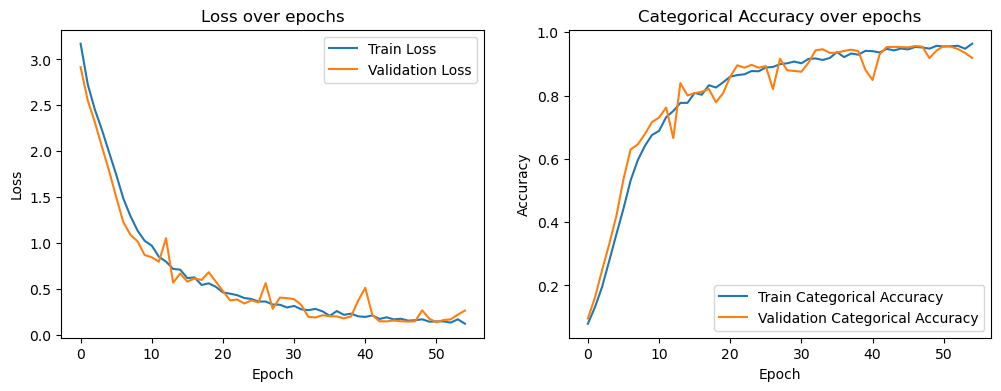

In [103]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Train Categorical Accuracy')
if 'val_categorical_accuracy' in history.history:
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Categorical Accuracy')
plt.title('Categorical Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [105]:
y_pred_probs = model.predict(x_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(y_true, y_pred, digits=4)
print(report)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0     0.9487    0.6491    0.7708        57
           1     0.9500    0.9828    0.9661        58
           2     1.0000    0.8254    0.9043        63
           3     0.9167    0.8627    0.8889        51
           4     1.0000    0.9796    0.9897        49
           5     0.9231    0.9231    0.9231        52
           6     0.9600    0.9231    0.9412        52
           7     0.7973    0.9516    0.8676        62
           8     0.9815    1.0000    0.9907        53
           9     0.9800    0.9608    0.9703        51
          10     1.0000    0.9020    0.9485        51
          11     0.9821    0.9821    0.9821        56
          12     0.8448    0.9074    0.8750        54
          13     0.8182    1.0000    0.9000        45
          14     0.9649    1.0000    0.9821        55
          15     0.9474    1.0000    0.9730        54
          16     1.0000    0.9000    0.94

In [107]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.9171 - loss: 0.2872
Test Loss: 0.2872
Test Accuracy: 0.9171


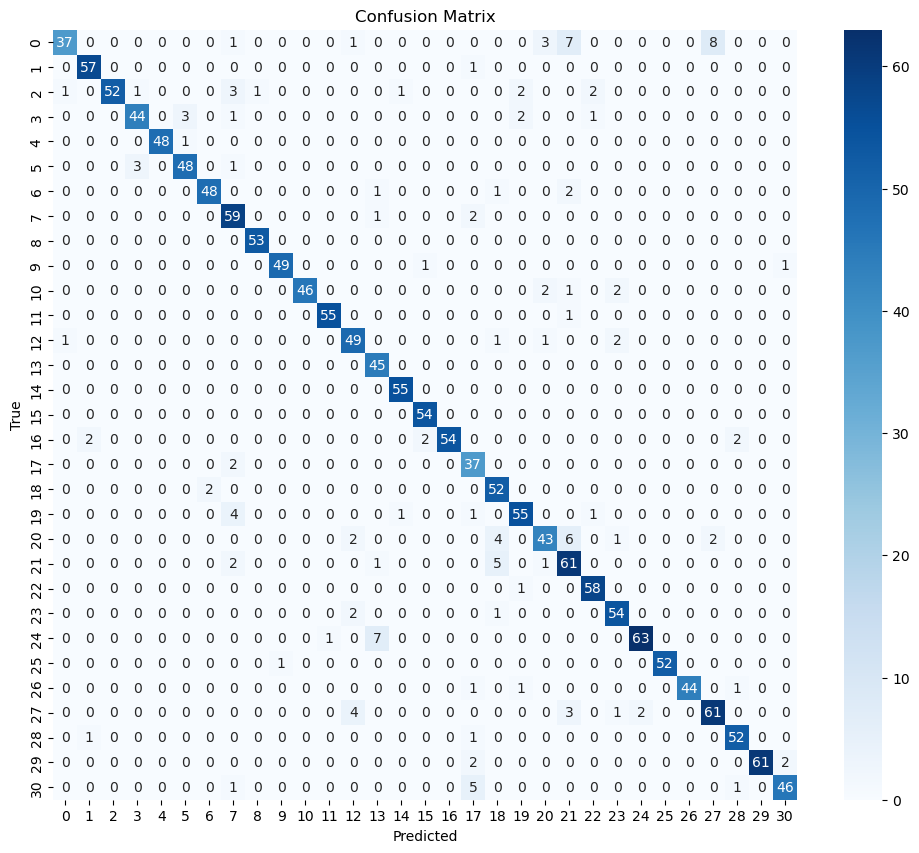

In [109]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [111]:
model.save('alphabet92.keras')

In [113]:
model.load_weights('alphabet92.keras')

## MSL Words

In [63]:
elapsed_time1 = end_time1 - start_time1
minutes1 = int(elapsed_time1 // 60)
seconds1 = int(elapsed_time1 % 60)

print(f"Training time: {minutes1} min {seconds1} sec")

Training time: 8 min 1 sec


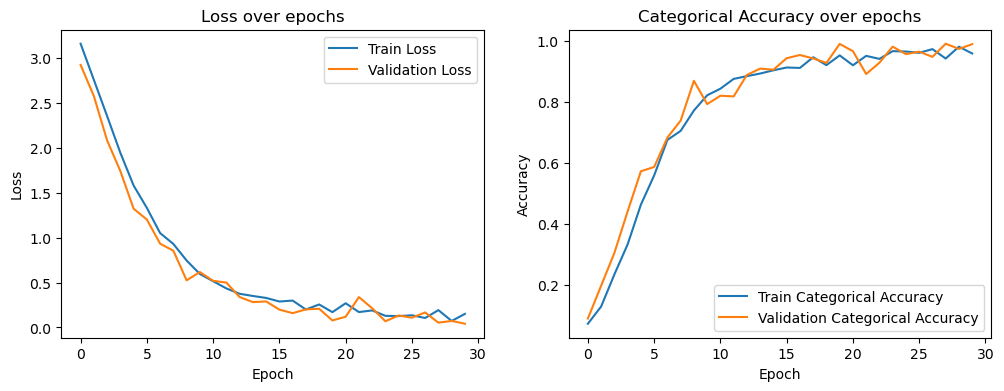

In [65]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')
if 'val_loss' in history1.history:
    plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history1.history['categorical_accuracy'], label='Train Categorical Accuracy')
if 'val_categorical_accuracy' in history1.history:
    plt.plot(history1.history['val_categorical_accuracy'], label='Validation Categorical Accuracy')
plt.title('Categorical Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [67]:
y_w_pred_probs = model1.predict(x_w_test)
y_w_true = np.argmax(y_w_test, axis=1)
y_w_pred = np.argmax(y_w_pred_probs, axis=1)

report1 = classification_report(y_w_true, y_w_pred, digits=4)
print(report1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        46
           1     0.9706    1.0000    0.9851        33
           2     1.0000    1.0000    1.0000        58
           3     1.0000    1.0000    1.0000        40
           4     1.0000    1.0000    1.0000        46
           5     1.0000    1.0000    1.0000        48
           6     1.0000    1.0000    1.0000        51
           7     1.0000    1.0000    1.0000        42
           8     1.0000    1.0000    1.0000        43
           9     0.9800    1.0000    0.9899        49
          10     1.0000    1.0000    1.0000        61
          11     1.0000    1.0000    1.0000        53
          12     1.0000    0.9828    0.9913        58
          13     1.0000    1.0000    1.0000        41
          14     1.0000    1.0000    1.0000        44
          15     0.9643    1.0000    0.9818        54
          16     1.0000    1.0000    1.00

In [69]:
test_loss1, test_acc1 = model1.evaluate(x_w_test, y_w_test)
print(f"Test Loss: {test_loss1:.4f}")
print(f"Test Accuracy: {test_acc1:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - categorical_accuracy: 0.9940 - loss: 0.0369
Test Loss: 0.0369
Test Accuracy: 0.9940


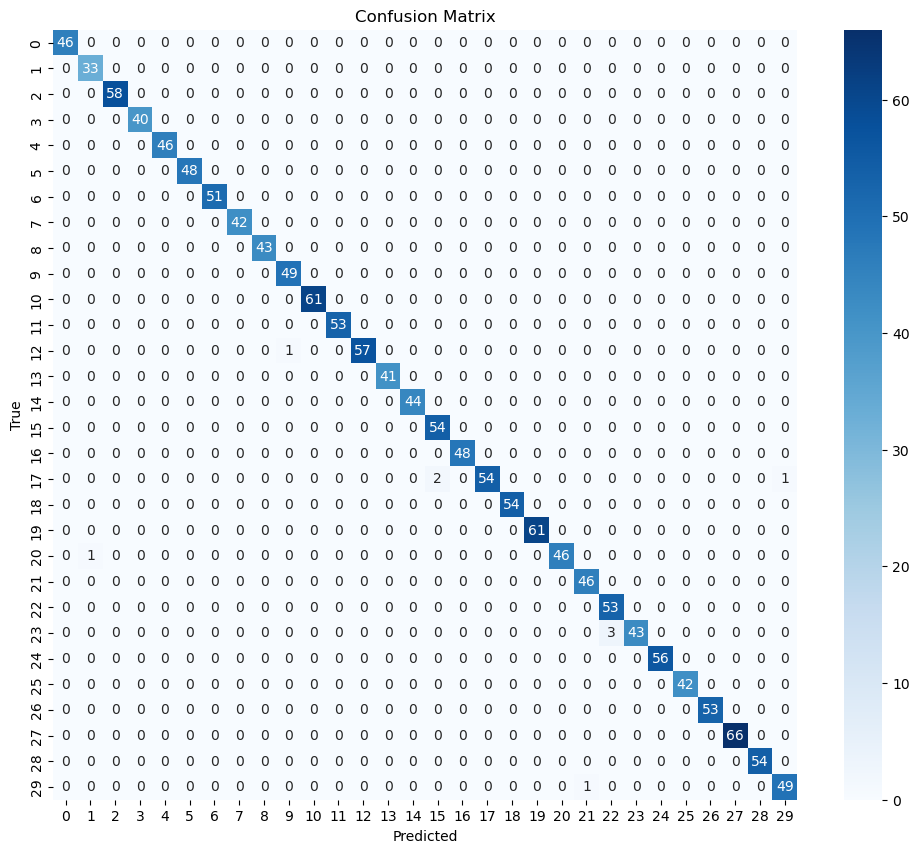

In [71]:
cm1 = confusion_matrix(y_w_true, y_w_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [5059]:
model1.save('words98.keras')

In [33]:
model1.load_weights('words98.keras')

# Real time predictions

In [37]:
def live_recognition(model, actions, action_labels, threshold = 0.8):
    sequence = []
    sentence = []
    predictions = []

    cap = cv2.VideoCapture(0) 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
    
            image, results = mediapipe_detection(frame, holistic)
            draw_landmarks(image, results)
        
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]
            
            if len(sequence) == 30:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))
                
                if np.unique(predictions[-10:])[0]==np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        if len(sentence) > 0: 
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(action_labels[np.argmax(res)])
                        else:
                            sentence.append(action_labels[np.argmax(res)])
    
                if len(sentence) > 5: 
                    sentence = sentence[-5:]
                
            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            cv2.imshow('OpenCV Feed', image)
    
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()

In [42]:
live_recognition(model1, words, word_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Мобилна мрежа
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Мобилна мрежа
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Мобилна мрежа
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Мобилна мрежа
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Мобилна мрежа
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Мобилна мрежа
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Мобилна мрежа
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Веб страна
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Веб страна
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Веб страна
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Светла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Светла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Светла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Светла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Светла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Светла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Светла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Светла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Светла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Светла
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
